In [1]:
import statsmodels.api as sm
from patsy import dmatrices

In [2]:
data = pd.read_csv('../data/bnbcosmic/trackfeatures_prodgenie_bnb_nu_cosmic_uboone_mcc8.7_cali_dev_pmtrack_truncated_test.csv',index_col=False)
data_c = pd.read_csv('../data/corsika_intime/trackfeatures_prodcosmics_corsika_cmc_uboone_intime_mcc8.7_reco2_dev_truncated_500000.csv',index_col=False)

In [3]:
data['mc_inTPC'] = np.where((data.mc_nux >= 3.45)&(data.mc_nux <= 249.8)&(data.mc_nuy >= -110.53)&(data.mc_nuy <= 112.47)&(data.mc_nuz >= 5.1)&(data.mc_nuz <= 1031.9), 1,0)

In [4]:
data['forward'] = np.where(data.theta <= np.pi/2., 1,0)
data_c['forward'] = np.where(data_c.theta <= np.pi/2., 1,0)

In [5]:
data_g = data[(data.inFiducial == 1)&(data.length >= 1.5)&(data.nbflash > 0)&(data.predict_p > 0.5)]

In [6]:
print len(data)
print len(data_g)

3227139
85369


In [7]:
data_cg = data_c[(data_c.inFiducial == 1)&(data_c.length >= 1.5)&(data_c.nbflash > 0)&(data_c.predict_p > 0.5)]

In [8]:
print len(data_c)
print len(data_cg)

500821
1806


In [9]:
data_g['nce'] = np.where((data_g.mc_mode == 0)&(data_g.mc_ccnc == 1)&(data_g.mc_hitnuc == 2212)&(data_g.mc_inTPC == 1)&(data_g.mcpdg == 2212)&(data_g.mcorigin == 1)&(data_g.mcprimary == 1), 1,0)
data_cg['nce'] = 0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Fit weights

In [10]:
data_nc = data_g[data_g.nce == 1]
data_bg = data_g[data_g.nce == 0]
data_g = pd.concat([data_nc,data_bg.iloc[:2000],data_cg.iloc[:2000]])

In [11]:
y, X = dmatrices('nce ~ predict_p + p_vtxdist + cfzabdiff + cfyabdiff + mu_evt_zfdist_min + pi_evt_zfdist_min + forward',data_g,return_type='dataframe')

In [12]:
print len(data_g)
print len(X)
print len(data_nc)

4804
4804
998


In [13]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.266563
         Iterations 9


In [20]:
print logitfit.summary()

8161.23834336
1.6988422863
                           Logit Regression Results                           
Dep. Variable:                    nce   No. Observations:                 4804
Model:                          Logit   Df Residuals:                     4796
Method:                           MLE   Df Model:                            7
Date:                Thu, 04 Oct 2018   Pseudo R-squ.:                  0.4783
Time:                        12:13:35   Log-Likelihood:                -1280.6
converged:                       True   LL-Null:                       -2454.6
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -5.9440      0.362    -16.406      0.000        -6.654    -5.234
predict_p_final       5.3890      0.402     13.400      0.000         4.601     6.1

In [48]:
print logitfit.summary2()

                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.448    
Dependent Variable:   nce              AIC:              2461.4144
Date:                 2018-06-29 11:02 BIC:              2511.7166
No. Observations:     3975             Log-Likelihood:   -1222.7  
Df Model:             7                LL-Null:          -2214.4  
Df Residuals:         3967             LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       8.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -5.5169   0.3641 -15.1531 0.0000 -6.2304 -4.8033
predict_p          4.4406   0.3732  11.8989 0.0000  3.7092  5.1720
p_vtxdist          0.0235   0.0013  17.5274 0.0000  0.0209  0.0261
cfzabdiff         -0.

In [21]:
print logitfit.params

Intercept           -5.943956
predict_p_final      5.388985
p_vtxdist            0.021189
cfzabdiff           -0.016710
cfyabdiff           -0.017510
mu_evt_zfdist_min    0.001084
pi_evt_zfdist_min    0.000989
forward              0.592240
dtype: float64


In [50]:
data_g['pred'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min'] + logitfit.params['forward']*data_g['forward']

2607
913


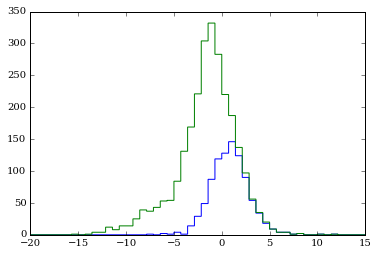

In [52]:
plt.hist(data_g[(data_g.mc_mode == 0)&(data_g.mc_ccnc == 1)&(data_g.mc_hitnuc == 2212)&(data_g.mc_inTPC == 1)].groupby(['run','event']).max().pred,bins=np.linspace(-20,15,50),histtype='step');
plt.hist(data_g.groupby(['run','event']).max().pred,bins=np.linspace(-20,15,50),histtype='step');
print len(data_g.groupby(['run','event']))
print len(data_g[data_g.nce == 1].groupby(['run','event']))

## Coefficient significance

In [55]:
data_g['ncprob'] = np.exp(data_g['pred'])/(1. + np.exp(data_g['pred']))

In [56]:
SSE = ((data_g['ncprob'] - data_g['nce'])**2).sum()

### predict_p

In [57]:
y, X = dmatrices('nce ~ p_vtxdist + cfzabdiff + cfyabdiff + forward + mu_evt_zfdist_min + pi_evt_zfdist_min + forward',data_g,return_type='dataframe')

In [58]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.327782
         Iterations 8


In [59]:
logitfit.params

Intercept           -1.812063
p_vtxdist            0.024228
cfzabdiff           -0.015339
cfyabdiff           -0.015354
forward              0.734703
mu_evt_zfdist_min    0.001028
pi_evt_zfdist_min    0.000958
dtype: float64

In [60]:
data_g['pred_01'] = logitfit.params['Intercept'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['forward']*data_g['forward'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min']
data_g['ncprob_01'] = np.exp(data_g['pred_01'])/(1.+ np.exp(data_g['pred_01']))

In [61]:
SSE_01 = ((data_g['ncprob_01'] - data_g['nce'])**2).sum()

In [62]:
print SSE - SSE_01

-29.4498107929


### p_vtxdist

In [64]:
y, X = dmatrices('nce ~ predict_p + cfzabdiff + cfyabdiff + forward + mu_evt_zfdist_min + pi_evt_zfdist_min',data_g,return_type='dataframe')

In [65]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.357694
         Iterations 8


In [66]:
logitfit.params

Intercept           -5.787145
predict_p            4.964753
cfzabdiff           -0.011195
cfyabdiff           -0.012621
forward              0.657803
mu_evt_zfdist_min    0.001361
pi_evt_zfdist_min    0.001139
dtype: float64

In [67]:
data_g['pred_02'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['forward']*data_g['forward'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min']
data_g['ncprob_02'] = np.exp(data_g['pred_02'])/(1.+ np.exp(data_g['pred_02']))

In [68]:
SSE_02 = ((data_g['ncprob_02'] - data_g['nce'])**2).sum()

In [69]:
print SSE - SSE_02

-73.2113560797


### cfzabdiff

In [70]:
y, X = dmatrices('nce ~ predict_p + p_vtxdist + cfyabdiff + forward + mu_evt_zfdist_min + pi_evt_zfdist_min',data_g,return_type='dataframe')

In [71]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.383605
         Iterations 7


In [72]:
logitfit.params

Intercept           -7.392017
predict_p            5.892671
p_vtxdist            0.016104
cfyabdiff           -0.018216
forward              0.649235
mu_evt_zfdist_min    0.001060
pi_evt_zfdist_min    0.000779
dtype: float64

In [74]:
data_g['pred_03'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['forward']*data_g['forward'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min']
data_g['ncprob_03'] = np.exp(data_g['pred_03'])/(1.+ np.exp(data_g['pred_03']))

In [75]:
SSE_03 = ((data_g['ncprob_03'] - data_g['nce'])**2).sum()

In [76]:
print SSE - SSE_03

-98.0967622938


### cfyabdiff

In [77]:
y, X = dmatrices('nce ~ predict_p + p_vtxdist + cfzabdiff + forward + mu_evt_zfdist_min + pi_evt_zfdist_min',data_g,return_type='dataframe')

In [78]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.315608
         Iterations 8


In [79]:
logitfit.params

Intercept           -6.260366
predict_p            4.636242
p_vtxdist            0.023064
cfzabdiff           -0.014420
forward              0.561326
mu_evt_zfdist_min    0.001036
pi_evt_zfdist_min    0.000886
dtype: float64

In [80]:
data_g['pred_04'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['forward']*data_g['forward'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min']
data_g['ncprob_04'] = np.exp(data_g['pred_04'])/(1.+ np.exp(data_g['pred_04']))

In [81]:
SSE_04 = ((data_g['ncprob_04'] - data_g['nce'])**2).sum()

In [82]:
print SSE - SSE_04

-11.0057116333


### forward

In [95]:
y, X = dmatrices('nce ~ predict_p + p_vtxdist + cfzabdiff + cfyabdiff + mu_evt_zfdist_min + pi_evt_zfdist_min',data_g,return_type='dataframe')

In [96]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.310519
         Iterations 8


In [97]:
logitfit.params

Intercept           -5.372370
predict_p            4.735581
p_vtxdist            0.023748
cfzabdiff           -0.013810
cfyabdiff           -0.014187
mu_evt_zfdist_min    0.001052
pi_evt_zfdist_min    0.000881
dtype: float64

In [98]:
data_g['pred_05'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min']
data_g['ncprob_05'] = np.exp(data_g['pred_05'])/(1.+ np.exp(data_g['pred_05']))

In [99]:
SSE_05 = ((data_g['ncprob_05'] - data_g['nce'])**2).sum()

In [100]:
print SSE - SSE_05

-4.0698987929


### mu_evt_zfdist_min

In [101]:
y, X = dmatrices('nce ~ predict_p + p_vtxdist + cfzabdiff + cfyabdiff + forward + pi_evt_zfdist_min',data_g,return_type='dataframe')

In [102]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.319540
         Iterations 8


In [103]:
logitfit.params

Intercept           -4.992915
predict_p            4.351386
p_vtxdist            0.025141
cfzabdiff           -0.013952
cfyabdiff           -0.013109
forward              0.479729
pi_evt_zfdist_min    0.001002
dtype: float64

In [104]:
data_g['pred_06'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['forward']*data_g['forward'] + logitfit.params['pi_evt_zfdist_min']*data_g['pi_evt_zfdist_min']
data_g['ncprob_06'] = np.exp(data_g['pred_06'])/(1.+ np.exp(data_g['pred_06']))

In [105]:
SSE_06 = ((data_g['ncprob_06'] - data_g['nce'])**2).sum()

In [106]:
print SSE - SSE_06

-17.3527686703


### pi_evt_zfdist_min

In [107]:
y, X = dmatrices('nce ~ predict_p + p_vtxdist + cfzabdiff + cfyabdiff + forward + mu_evt_zfdist_min',data_g,return_type='dataframe')

In [108]:
logit = sm.Logit(y,X,missing='drop')
logitfit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.313834
         Iterations 8


In [109]:
logitfit.params

Intercept           -4.965909
predict_p            4.534842
p_vtxdist            0.024297
cfzabdiff           -0.013466
cfyabdiff           -0.013655
forward              0.497863
mu_evt_zfdist_min    0.001138
dtype: float64

In [111]:
data_g['pred_07'] = logitfit.params['Intercept'] + logitfit.params['predict_p']*data_g['predict_p'] + logitfit.params['p_vtxdist']*data_g['p_vtxdist'] + logitfit.params['cfzabdiff']*data_g['cfzabdiff'] + logitfit.params['cfyabdiff']*data_g['cfyabdiff'] + logitfit.params['forward']*data_g['forward'] + logitfit.params['mu_evt_zfdist_min']*data_g['mu_evt_zfdist_min']
data_g['ncprob_07'] = np.exp(data_g['pred_07'])/(1.+ np.exp(data_g['pred_07']))

In [112]:
SSE_07 = ((data_g['ncprob_07'] - data_g['nce'])**2).sum()

In [113]:
print SSE - SSE_07

-8.09427299731


In [114]:
print 'predict_p: %s' %(SSE - SSE_01)
print 'p_vtxdist: %s' %(SSE - SSE_02)
print 'cfzabdiff: %s' %(SSE - SSE_03)
print 'cfyabdiff: %s' %(SSE - SSE_04)
print 'forward: %s' %(SSE - SSE_05)
print 'mu_evt_zfdist_min: %s' %(SSE - SSE_06)
print 'pi_evt_zfdist_min: %s' %(SSE - SSE_07)

predict_p: -29.4498107929
p_vtxdist: -73.2113560797
cfzabdiff: -98.0967622938
cfyabdiff: -11.0057116333
forward: -4.0698987929
mu_evt_zfdist_min: -17.3527686703
pi_evt_zfdist_min: -8.09427299731
